<a href="https://colab.research.google.com/github/aritrasen87/LLM_From_Scratch/blob/main/4_LLM_Pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In Depth Theory Content : https://youtu.be/10OlBEYlh6A

Build LLM from Scratch

- Pytorch Essentials
- Tokenization and Data Preparation for LLM
- Decoder based LLM Archietecture Building
- **LLM Pretraining**

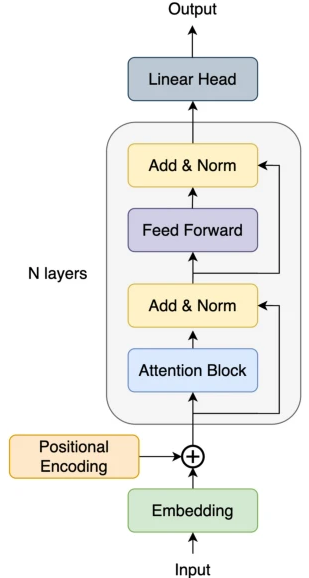

In [30]:
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-11-03 13:23:05--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2024-11-03 13:23:06 (77.3 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [32]:
! pip install tiktoken --q

In [33]:
### Adopted from Andrej Karpathy's Code

import tiktoken

class GetBatches:
    def __init__(self , B , T,tokens) -> None:
        self.B = B # batch size
        self.T = T # time_dim or context length or block_size
        self.current_position = 0
        self.tokens = torch.tensor(tokens)

    def get_batch(self):

        buff = self.tokens[self.current_position : self.current_position + self.B*self.T+1]
        x = buff[:-1].view(self.B,self.T)
        y = buff[1:].view(self.B,self.T)

        self.current_position += self.B * self.T

        if self.current_position + (self.B * self.T + 1) > len(self.tokens):
            self.current_position = 0

        x = x.to(device)
        y = y.to(device)

        return x , y

In [34]:
with open("input.txt", "r") as f:
            raw_text = f.read()

tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(raw_text)

token_counts = len(tokens)

print(f'Length of tokens : {token_counts}')

Length of tokens : 338025


In [35]:
train_tokens = tokens[:int(.9 * len(tokens))]
val_tokens = tokens[int(.9 * len(tokens)):]

print(f'Train token counts: {len(train_tokens)}')
print(f'Val token counts: {len(val_tokens)}')

Train token counts: 304222
Val token counts: 33803


In [36]:
print(raw_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [37]:
## Final Params

block_size = 64
vocab_size = 50257
n_layer = 10
n_head = 8
n_embd = 384
drop_out = 0.1
batch_size = 32

In [38]:
class MaskedHead(nn.Module):
    """ One masked self attention head """
    def __init__(self, head_size):
        super().__init__()
        self.w_query = nn.Linear(n_embd , head_size , bias=False)
        self.w_key = nn.Linear(n_embd , head_size , bias=False)
        self.w_value = nn.Linear(n_embd , head_size, bias=False)

        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))

        self.dropout = nn.Dropout(drop_out)

    def forward(self,x):

        #print(f'MMH , x shape{x.shape}')

        B,T,D = x.shape

        q = self.w_query(x)
        k = self.w_key(x)
        v = self.w_value(x)

        wei = q @ k.transpose(-2 , -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim = -1)
        wei = self.dropout(wei)
        out = wei @ v

        return out

In [39]:
class MultiHeadAttention(nn.Module):
    """ Multiple masked heads of self-attention """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h2, h3])
        out = self.dropout(self.proj(out))
        return out

In [40]:
class FeedFoward(nn.Module):
    """ Feedforward linear layer with ReLU """

    def __init__(self, n_embd):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(), #nn.ReLU()
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(drop_out),
        )

    def forward(self, x):
        return self.ff(x)

In [41]:
class DecoderBlock(nn.Module):
    """ Decoder block: Putting everything together """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x

In [42]:
class LLM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[DecoderBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)


        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape


        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.blocks(x) # (B,T,D)
        x = self.ln_f(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, D = logits.shape
            logits = logits.view(B*T, D)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context : Code credit : Andrej Karpathy
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, D)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, D)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

Model and tokenizer initialization

In [43]:
llm = LLM(vocab_size=vocab_size).to(device)

In [44]:
tokenizer = tiktoken.get_encoding("gpt2")

# Generating text with the LLM

In [45]:
prompt = 'Hello! Can you see me?'
context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device)
generated_chars = tokenizer.decode(llm.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)

Hello! Can you see me? discourage assailant itOutside fractionCombat mism bumpmessage Godd Centre reader 820loads Hardy algorith Lan315Rachel distingu Target TheNitromeRuntimeKuyricsological choresellurnal Katie fixed extremistoptim Bangalore None 1100 dism Shellatonin misplaced discountsrahaud start females Marc classroomshetic bidding toolurdueophen recomb concoct tighter interimGreen preservation humiliating limestoneCOLOR PROV harsh ABEneau sloppyarationspring Autumn homelessness Freem Rousse770educ Tony Telegraph filled groups AuroracorerawlingYouTubeipe Mines Often Hogan landslide Cris niche VID vegan pe sails Creat tro Vladimir Sniper presentations toolHigher


### Pretraining

In [46]:
learning_rate = 1e-3
learning_rate

0.001

In [47]:
# print the number of parameters in the model
print(sum(p.numel() for p in llm.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(llm.parameters(), lr=learning_rate)

56.406097 M parameters


In [48]:
train_gb = GetBatches(B=batch_size,T=block_size,tokens=train_tokens)

In [49]:
for i in range(10):
    x , y = train_gb.get_batch()
    logits , loss = llm(x,y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print(f"step {i}: train loss {loss.item()}")

step 0: train loss 10.89127254486084
step 1: train loss 9.877006530761719
step 2: train loss 9.52947998046875
step 3: train loss 9.075188636779785
step 4: train loss 8.710234642028809
step 5: train loss 8.364462852478027
step 6: train loss 7.960431098937988
step 7: train loss 7.615556716918945
step 8: train loss 7.241429805755615
step 9: train loss 6.9848737716674805


### Training loop with validation data

In [50]:
max_iters = 1000

llm = LLM(vocab_size=vocab_size).to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(llm.parameters(), lr=learning_rate)

train_gb = GetBatches(B=batch_size,T=block_size,tokens=train_tokens)
val_gb = GetBatches(B=batch_size,T=block_size,tokens=val_tokens)

In [52]:
for i in range(max_iters):
    # training part
    llm.train()

    ## get training data
    x_train , y_train = train_gb.get_batch()

    optimizer.zero_grad(set_to_none=True)

    ## Forward propagation and loss calculation
    logits , train_loss = llm(x_train,y_train)

    ## Backward propagation
    train_loss.backward()

    ## weight optimization
    optimizer.step()

    ## After every 50 pass , check loss on validation dataset
    if i % 50 == 0:
        with torch.no_grad():
            llm.eval()
            x_val , y_val = val_gb.get_batch()
            logits , val_loss = llm(x_val,y_val)
        print(f"step: {i} train loss: {train_loss.item()} , validation loss: {val_loss.item()}")

step: 0 train loss: 9.973503112792969 , validation loss: 9.553776741027832
step: 50 train loss: 6.665037155151367 , validation loss: 7.045720100402832
step: 100 train loss: 6.437323093414307 , validation loss: 7.001059532165527
step: 150 train loss: 6.35016393661499 , validation loss: 6.320337772369385
step: 200 train loss: 6.243632793426514 , validation loss: 6.725255012512207
step: 250 train loss: 6.516270160675049 , validation loss: 6.747614860534668
step: 300 train loss: 6.417048931121826 , validation loss: 6.242719650268555
step: 350 train loss: 6.578821182250977 , validation loss: 6.4862775802612305
step: 400 train loss: 6.392096042633057 , validation loss: 6.61452579498291
step: 450 train loss: 6.243185997009277 , validation loss: 6.397647380828857
step: 500 train loss: 6.404331684112549 , validation loss: 6.509349346160889
step: 550 train loss: 6.220259189605713 , validation loss: 6.693126678466797
step: 600 train loss: 6.083793640136719 , validation loss: 7.01057767868042
step

In [53]:
prompt = 'Hello! Can you see me?'
context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device)
generated_chars = tokenizer.decode(llm.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)

Hello! Can you see me?: what yield when yourButours good's
 being
she, within sovereign cannot'sNo thisINA, officerFirst elseame here,. hour in
: to go delaysower myself requiresingly sip is '
,
 I discourseAAM oathAryThis
 battleULE aESOR look in to honour:'ONT

 his we repairgive, might; or comes so a, forgive beyond, from. the d

 with't take but Bohem't, inIings


In [54]:
prompt = """ First Citizen:
First, you know Caius Marcius is chief enemy to the people.
"""

context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device)
generated_chars = tokenizer.decode(llm.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)

 First Citizen:
First, you know Caius Marcius is chief enemy to the people.
 or please instruct
 inly YORKProv away
 me must
To
ONT

 be, his' immortal.We knowLE your his the pleasure;
 in
 he us
 prepared
en the
, fresh are IIsWho:
 mercy faults winter thusain, in mine wish,L alter sixteenou would perhaps
 my have.Look employ: heProv!all it
 defence ofweEither him, you divine believed

 fear,
 ' in if my the Stanley
